# Selection criterion size convex hull pt.II: Multimeric clusters
# Convex hull as diagnostic tool in single-molecule localization microscopy

The first part of selection criterion was to identify merged clusters which occur more frequently at higher density data. In biological samples, they can also occur if the global density is low but locally, densities are high due to underlying structures that lead to increased expression of monomers. \
Here, the scenario of multimeres is investigated. This means that the underlying structures of each cluster can be clustering by themselves. 

In this analysis, clustering clusters were generated via simulations.sim_clusters, generating a defined amount of multimeres. The single clusters making up one multimere are Poisson distributed within a circular area. \
Alternatively, simulations.sim_random_walk generates more randomly shaped and amounts of multimeres. In both cases, the array original_size can be used to differntiate between multimeres and monomeres of the ground truth.

In [1]:
import numpy as np
import pandas as pd
import py_files.selection_criterion_multimere as scmulti
import py_files.simulations as si
import py_files.convex_hull as ch
from py_files.matplotlib_custom import second_axis, second_axis_log

import colorcet as cc
import boost_histogram as bh
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

## Load lookup table of area convex hull
Contains mean, standard deviation of areas of the convex hull, can be scaled with certain factors

In [2]:
lookup_table = pd.read_csv(r"Lookup_tables\lookup_table_area_2d.csv", index_col=0)
mean = lookup_table.loc["$E(A_{ch}(n))$"].astype(float).values
std_pos = lookup_table.loc["$std_{pos}(n)$"].astype(float).values

Scale the values of the lookup table to the desired localization precision of the data simulation. In the case of the area, it is localization precision squared.

In [3]:
cluster_std = 8
max_areas_1sigma = (mean + std_pos)*cluster_std**2
max_areas_2sigma = (mean + 2*std_pos)*cluster_std**2
max_areas_3sigma = (mean + 3*std_pos)*cluster_std**2
max_areas_4sigma = (mean + 4*std_pos)*cluster_std**2
max_areas_5sigma = (mean + 5*std_pos)*cluster_std**2

## Table of different measures to evaluate the method using different threshold levels
Data is simulated, clustered and analyzed. The clusters areas that exceed the applied threshold are the target of this method. They can be filtered out or stored elsewhere. 

Note: The true positives are simulated multimeres. The method still identifies merged clusters that can occur even at low density data. They should be identified by the method but are not included into true positives here.

In [4]:
parent_intensity = 1e-5
limit = si.limits([parent_intensity], 15e-5, 5000)
sim_param = dict(parent_intensity=parent_intensity, cluster_mu=9, cluster_std=8, min_samples=3, 
                 seed=np.random.default_rng(100), lower_limit=-limit[0], upper_limit=limit[0], ratio=0.2, 
                 replace_mu=4, mode="poisson")
alg_param = dict(eps=25, min_samples=3)
radii = [8, 12, 16, 20, 24, 28, 32]
n_simulations = 30
max_areas = [max_areas_1sigma, max_areas_2sigma, max_areas_3sigma, max_areas_4sigma, max_areas_5sigma]
max_areas_keys = ["1 sigma", "2 sigma", "3 sigma", "4 sigma", "5 sigma"]
scmulti_means, scmulti_stds, scmulti_representation = \
    scmulti.selection_criterion_analysis_multimeres(n_simulations, radii, sim_param, alg_param, max_areas,
                                                    max_areas_keys)
scmulti_representation.to_csv("Selection_criterion_data\scmulti_means_stds.csv")
scmulti_means.to_csv("Selection_criterion_data\scmulti_means.csv")
scmulti_stds.to_csv("Selection_criterion_data\scmulti_stds.csv")

## The portion of multimeres of the algorithm per radius of simulation.sim_cluster

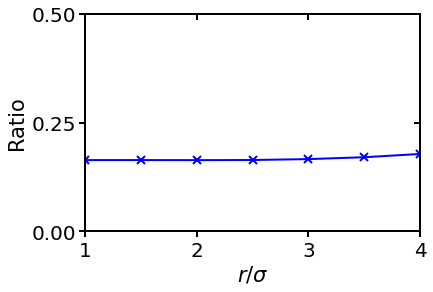

In [5]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(6, 4))
x = scmulti_means.index.levels[0]/cluster_std
y = scmulti_means.loc[(slice(None), scmulti_means.index.levels[1][0]), "Algorithm multimeres"].values
yerr = scmulti_stds.loc[(slice(None), scmulti_stds.index.levels[1][0]), "Algorithm multimeres"].values
ax.errorbar(x, y, yerr=yerr, lw=2, color="blue", zorder=1, marker="x", ms=8, mew=2, ecolor="blue")
ax.set_ylim(0, 0.5)
ax.tick_params(labelsize=20, width=2, length=6)
ax.set_ylabel("Ratio", fontsize=21)
ax.set_xlabel("$r/\sigma$", fontsize=21)
ax.set_xlim(1, 4)
tick_spacing_x = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_x))
tick_spacing_y = 0.25
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
fig.savefig(r"Figures\Figure X\multimeres_per_radius.svg")

## The portion of subdivided multimeres of the algorithm per radius of simulation.sim_cluster

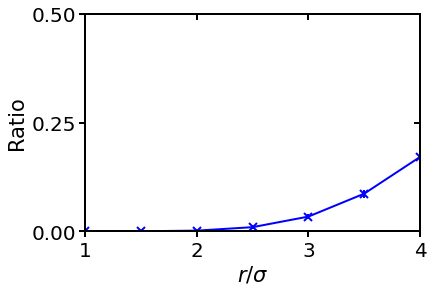

In [6]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(6, 4))
x = scmulti_means.index.levels[0]/cluster_std
y = scmulti_means.loc[(slice(None), scmulti_means.index.levels[1][0]), "Multimere subdivision algorithm"].values
yerr = scmulti_stds.loc[(slice(None), scmulti_stds.index.levels[1][0]), "Multimere subdivision algorithm"].values
ax.errorbar(x, y, yerr=yerr, lw=2, color="blue", zorder=1, marker="x", ms=8, mew=2, ecolor="blue")
ax.set_ylim(0, 0.5)
ax.tick_params(labelsize=20, width=2, length=6)
ax.set_ylabel("Ratio", fontsize=21)
ax.set_xlabel("$r/\sigma$", fontsize=21)
ax.set_xlim(1, 4)
tick_spacing_x = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_x))
tick_spacing_y = 0.25
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
fig.savefig(r"Figures\Figure X\subdiv_multimeres_per_radius.svg")

## The portion of true and false positives with selection by convex hull

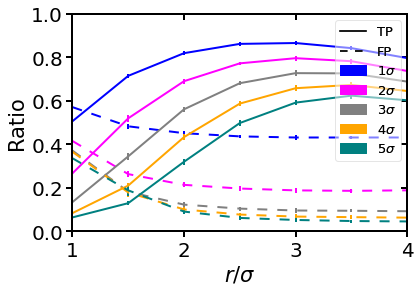

In [7]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(6, 4))
x = scmulti_means.index.levels[0]/cluster_std
color = ["blue", "magenta", "grey", "orange", "teal"]
patches = {}
for i, threshold in enumerate(scmulti_means.index.levels[1]):
    tp = scmulti_means.loc[(slice(None), threshold), "True positives"].values
    tp_yerr = scmulti_stds.loc[(slice(None), threshold), "True positives"].values
    fp = scmulti_means.loc[(slice(None), threshold), "False positives"].values
    fp_yerr = scmulti_stds.loc[(slice(None), threshold), "False positives"].values
    ax.errorbar(x, tp, yerr=tp_yerr, label=threshold, c=color[i], lw=2, marker="", markeredgewidth=2)
    ax.errorbar(x, fp, yerr=fp_yerr, ls=(0, (5, 5)), label=threshold, c=color[i], lw=2, marker="", 
                markeredgewidth=2)
    patches["patch{0}".format(i)] = mpatches.Patch(color=color[i], label=str(i+1) + r"$\sigma$")

handles_legend = [mlines.Line2D([], [], label="TP", c="k", marker=""), 
                  mlines.Line2D([], [], label="FP", linestyle=(0, (5, 5)), c="k", marker="")]
for patch in patches.values():
    handles_legend.append(patch)
second_legend = ax.legend(handles=handles_legend, loc=1, fontsize=13, framealpha=0.3)
ax.add_artist(second_legend)
ax.set_xlabel("$r/\sigma$", fontsize=21)
ax.set_ylabel("Ratio", fontsize=21)
ax.tick_params(labelsize=20, width=2, length=6)
tick_spacing_x = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_x))
tick_spacing_y = 0.2
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
ax.set_ylim(0, 1)
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
ax.set_xlim(1, 4)
fig.savefig(r"Figures\Figure X\TP_FP_method.svg")

## The portion of true and false postives with selection by n

In [8]:
n_simulations = 30
radii = [8, 12, 16, 20, 24, 28, 32]
parent_intensity = 1e-5
limit = si.limits([parent_intensity], 15e-5, 5000)
alg_param = dict(eps=25, min_samples=3)
sim_param = dict(parent_intensity=parent_intensity, cluster_mu=9, cluster_std=8, min_samples=3, 
                 seed=np.random.default_rng(100), lower_limit=-limit[0], upper_limit=limit[0], ratio=0.2, 
                 replace_mu=4, mode="poisson")
max_sample_counts = [10, 15, 20, 25, 30]
sample_count_means, sample_count_stds = scmulti.selection_multimeres_by_sample_count(n_simulations, radii, 
                                                                                     sim_param, alg_param, 
                                                                                     max_sample_counts)
np.save(file=r"Selection_criterion_data\multimeres_sample_count_means.npy", arr=sample_count_means)
np.save(file=r"Selection_criterion_data\multimeres_sample_count_stds", arr=sample_count_stds)

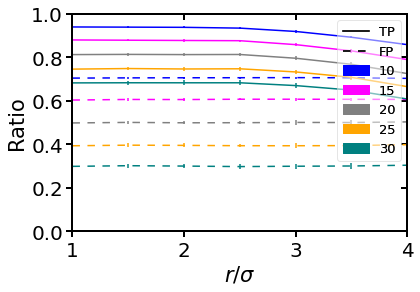

In [9]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(6, 4))
x = np.array(radii)/cluster_std
color = ["blue", "magenta", "grey", "orange", "teal"]
patches = {}
for i, max_sample_count in enumerate(max_sample_counts):
    fp = sample_count_means[:, i, 0]
    fp_yerr = sample_count_stds[:, i, 0]
    tp = sample_count_means[:, i, 1]
    tp_yerr = sample_count_stds[:, i, 0]
    ax.errorbar(x, fp, yerr=fp_yerr, ls=(0, (5, 5)), c=color[i], marker="", markeredgewidth=2)
    ax.errorbar(x, tp, yerr=tp_yerr, c=color[i], marker="", markeredgewidth=2)
    patches["patch{0}".format(i)] = mpatches.Patch(color=color[i], label=max_sample_count)
handles_legend = [mlines.Line2D([], [], label="TP", c="k", marker=""), 
                  mlines.Line2D([], [], label="FP", linestyle=(0, (5, 5)), c="k", marker="")]
for patch in patches.values():
    handles_legend.append(patch)
second_legend = ax.legend(handles=handles_legend, loc=1, fontsize=13, framealpha=0.3)
ax.add_artist(second_legend)
ax.set_xlabel("$r/\sigma$", fontsize=21)
ax.set_ylabel("Ratio", fontsize=21)
ax.tick_params(labelsize=20, width=2, length=6)
tick_spacing_x = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_x))
tick_spacing_y = 0.2
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
ax.set_ylim(0, 1)
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
ax.set_xlim(1, 4)
fig.savefig(r"Figures\Figure X\TP_FP_n_filter.svg")

## 2D Histograms of the area of the convex hull per n.

In [10]:
sim_param = dict(parent_intensity=1e-5, cluster_mu=9, cluster_std=8, min_samples=3, 
                 seed=np.random.default_rng(100), lower_limit=-5000, upper_limit=5000, ratio=0.2, 
                 replace_mu=4, mode="poisson")
radius_1 = 8
radius_2 = 24
alg_param = dict(eps=25, min_samples=3)
max_area = max_areas_2sigma
simulation_1, algorithm_1, post_selection_1, multimeres_1 = \
    scmulti.visualization_selection_multimeres(radius_1, sim_param, alg_param, max_area)
simulation_2, algorithm_2, post_selection_2, multimeres_2 = \
    scmulti.visualization_selection_multimeres(radius_2, sim_param, alg_param, max_area)

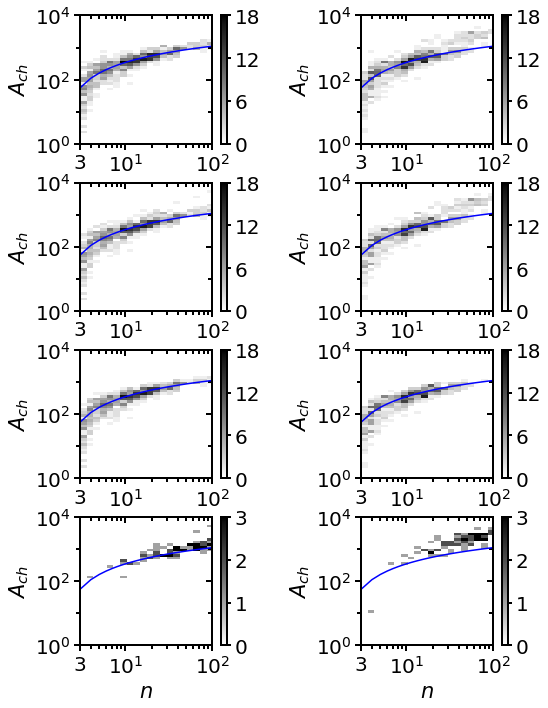

In [11]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(4, 2, figsize=(8, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.7, top=1)
n = np.linspace(3, 100, 98)
axes = bh.axis.AxesTuple((
    bh.axis.Regular(20, 3, 103, transform=bh.axis.transform.log),
    bh.axis.Regular(50, 1, 15000, transform=bh.axis.transform.log)
))
histogram = bh.Histogram(*axes)
y_1 = [simulation_1, algorithm_1, post_selection_1, multimeres_1,
       simulation_2, algorithm_2, post_selection_2, multimeres_2]
vmax_1 = [18, 18, 18, 3, 18, 18, 18, 3]
cbar_spacing_1 = [6, 6, 6, 1, 6, 6, 6, 1]
axeses = np.concatenate((ax[:, 0], ax[:, 1]))

for i, axis in enumerate(axeses):
    histogram.reset()
    histogram.fill(*y_1[i])
    mesh = axis.pcolormesh(*histogram.axes.edges.T, histogram.view().T, vmin=0, vmax=vmax_1[i], 
                           cmap=cc.m_gray.reversed(), zorder=0)
    cbar = fig.colorbar(mesh, ax=axis)
    cbar.ax.yaxis.set_major_locator(ticker.MultipleLocator(cbar_spacing_1[i]))
    cbar.ax.tick_params(width=2, length=4, labelsize=20)
    axis.plot(n, ch.calc_area_convex_hull_2d_pt2(8, n), "-", color="b")
    axis.set_xscale("log")
    axis.set_yscale("log")
    axis.set_ylabel(r"$A_{ch}$", fontsize=21)
    axis.set_xlabel(r"$n$", fontsize=21)
    tick_spacing_x = 10
    axis.xaxis.set_major_locator(ticker.LogLocator(base=tick_spacing_x))
    tick_spacing_y = 100
    axis.yaxis.set_major_locator(ticker.LogLocator(base=tick_spacing_y))
    axis.tick_params(labelsize=20, width=2, length=6)
    axis.yaxis.set_minor_locator(ticker.LogLocator(numticks=10, subs=(1., 10.), base=10))
    axis.xaxis.set_minor_locator(ticker.LogLocator(numticks=10, subs=(2., 3., 4., 5., 6., 7., 8., 9.), base=10))
    axis.tick_params(which="minor", width=2, length=4, labelleft=False, left=True)
    second_axis_log(axis, "top", tick_spacing_x)
    second_axis_log(axis, "right", tick_spacing_y)
    axis.set_ylim(1, 1e4)
    xtick = axis.get_xticks()
    np.append(xtick, [3])
    xtick[-1] = 3
    labels = [item.get_text() for item in axis.get_xticklabels()]
    for i in range(len(xtick)):
        l = int(np.log10(xtick[i]))
        labels[i] = r"$10^{}$".format(l)
    labels[-1] = "3"
    axis.set_xticks(xtick)
    axis.set_xticklabels(labels)
    axis.set_xlim(3, 1e2)

fig.savefig(r"Figures\Figure X\2d_histograms.svg")

## Visualization of multimeres and their subdivision

In [12]:
radius = 35
sim_param = dict(parent_intensity=1e-5, cluster_mu=9, cluster_std=8, min_samples=3, 
                 seed=np.random.default_rng(100), lower_limit=-5000, upper_limit=5000, ratio=0.2, 
                 replace_mu=4, mode="poisson")
alg_param = dict(eps=25, min_samples=3)
samples, coordinates_sim, coordinates_alg, multimere_indices = scmulti.visualization_multimeres(radius, sim_param,
                                                                                                alg_param)

### A simulated multimere

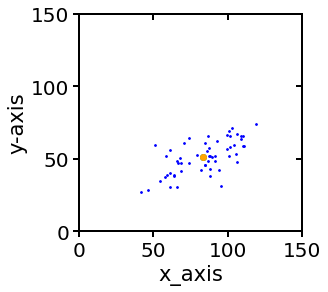

In [13]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(samples[:, 0], samples[:, 1], s=3, color="blue")
ax.scatter(coordinates_sim[:, 0], coordinates_sim[:, 1], color="teal")
ax.scatter(coordinates_sim[multimere_indices][:, 0], coordinates_sim[multimere_indices][:, 1], color="orange")
ax.set_xlim(600, 750)
ax.set_ylim(350, 500)
tick_spacing_x = 50
x_ticker = ticker.MultipleLocator(tick_spacing_x)
ax.xaxis.set_major_locator(x_ticker)
tick_spacing_y = 50
y_ticker = ticker.MultipleLocator(tick_spacing_y)
ax.yaxis.set_major_locator(y_ticker)
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
ax.tick_params(labelsize=20, width=2, length=6)
ax.set_ylabel("y-axis", fontsize=21)
ax.set_xlabel("x_axis", fontsize=21)
x_ticks = x_ticker.tick_values(601, 749)
ax.set_xticks(x_ticks)
x_labels = [item.get_text() for item in ax.get_xticklabels()]
for i in range(len(x_ticks)):
    x_labels[i] = str(0 + 50*i)
ax.set_xticklabels(x_labels)
y_ticks = y_ticker.tick_values(351, 499)
ax.set_yticks(y_ticks)
y_labels = [item.get_text() for item in ax.get_yticklabels()]
for i in range(len(y_ticks)):
    y_labels[i] = str(0 + 50*i)
ax.set_yticklabels(y_labels)
fig.savefig(r"Figures\Figure X\Multimeres_scatter_1.svg")

### The identified cluster by DBScan of the aboves multimere

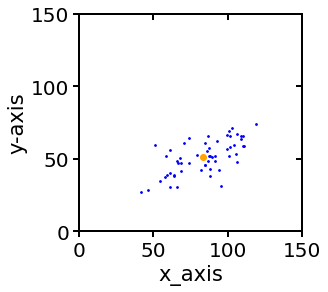

In [14]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(samples[:, 0], samples[:, 1], s=3, color="blue")
ax.scatter(coordinates_alg[:, 0], coordinates_alg[:, 1], color="orange")
ax.set_xlim(600, 750)
ax.set_ylim(350, 500)
tick_spacing_x = 50
x_ticker = ticker.MultipleLocator(tick_spacing_x)
ax.xaxis.set_major_locator(x_ticker)
tick_spacing_y = 50
y_ticker = ticker.MultipleLocator(tick_spacing_y)
ax.yaxis.set_major_locator(y_ticker)
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
ax.tick_params(labelsize=20, width=2, length=6)
ax.set_ylabel("y-axis", fontsize=21)
ax.set_xlabel("x_axis", fontsize=21)
x_ticks = x_ticker.tick_values(601, 749)
ax.set_xticks(x_ticks)
x_labels = [item.get_text() for item in ax.get_xticklabels()]
for i in range(len(x_ticks)):
    x_labels[i] = str(0 + 50*i)
ax.set_xticklabels(x_labels)
y_ticks = y_ticker.tick_values(351, 499)
ax.set_yticks(y_ticks)
y_labels = [item.get_text() for item in ax.get_yticklabels()]
for i in range(len(y_ticks)):
    y_labels[i] = str(0 + 50*i)
ax.set_yticklabels(y_labels)
fig.savefig(r"Figures\Figure X\Multimeres_scatter_2.svg")

### Another simulated multimere

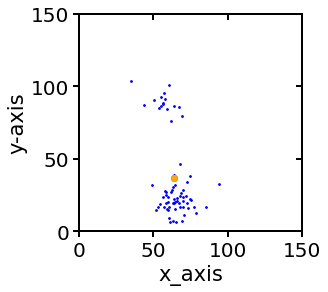

In [15]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(samples[:, 0], samples[:, 1], s=3, color="blue")
ax.scatter(coordinates_sim[:, 0], coordinates_sim[:, 1], color="teal")
ax.scatter(coordinates_sim[multimere_indices][:, 0], coordinates_sim[multimere_indices][:, 1], color="orange")
ax.set_xlim(-3150, -3000)
ax.set_ylim(-1250, -1100)
tick_spacing_x = 50
x_ticker = ticker.MultipleLocator(tick_spacing_x)
ax.xaxis.set_major_locator(x_ticker)
tick_spacing_y = 50
y_ticker = ticker.MultipleLocator(tick_spacing_y)
ax.yaxis.set_major_locator(y_ticker)
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
ax.tick_params(labelsize=20, width=2, length=6)
ax.set_ylabel("y-axis", fontsize=21)
ax.set_xlabel("x_axis", fontsize=21)
x_ticks = x_ticker.tick_values(-3149, -3001)
ax.set_xticks(x_ticks)
x_labels = [item.get_text() for item in ax.get_xticklabels()]
for i in range(len(x_ticks)):
    x_labels[i] = str(0 + 50*i)
ax.set_xticklabels(x_labels)
y_ticks = y_ticker.tick_values(-1249, -1101)
ax.set_yticks(y_ticks)
y_labels = [item.get_text() for item in ax.get_yticklabels()]
for i in range(len(y_ticks)):
    y_labels[i] = str(0 + 50*i)
ax.set_yticklabels(y_labels)
fig.savefig(r"Figures\Figure X\Multimeres_scatter_3.svg")

### The identified clusters (subdivision) by DBScan of the aboves multimere

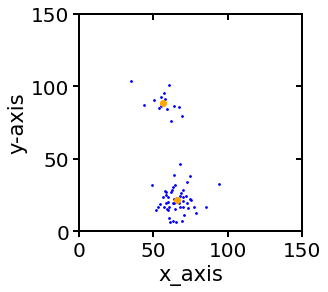

In [16]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(samples[:, 0], samples[:, 1], s=3, color="blue")
ax.scatter(coordinates_alg[:, 0], coordinates_alg[:, 1], color="orange")
ax.set_xlim(-3150, -3000)
ax.set_ylim(-1250, -1100)
tick_spacing_x = 50
x_ticker = ticker.MultipleLocator(tick_spacing_x)
ax.xaxis.set_major_locator(x_ticker)
tick_spacing_y = 50
y_ticker = ticker.MultipleLocator(tick_spacing_y)
ax.yaxis.set_major_locator(y_ticker)
second_axis(ax, "top", tick_spacing_x)
second_axis(ax, "right", tick_spacing_y)
ax.tick_params(labelsize=20, width=2, length=6)
ax.set_ylabel("y-axis", fontsize=21)
ax.set_xlabel("x_axis", fontsize=21)
x_ticks = x_ticker.tick_values(-3149, -3001)
ax.set_xticks(x_ticks)
x_labels = [item.get_text() for item in ax.get_xticklabels()]
for i in range(len(x_ticks)):
    x_labels[i] = str(0 + 50*i)
ax.set_xticklabels(x_labels)
y_ticks = y_ticker.tick_values(-1249, -1101)
ax.set_yticks(y_ticks)
y_labels = [item.get_text() for item in ax.get_yticklabels()]
for i in range(len(y_ticks)):
    y_labels[i] = str(0 + 50*i)
ax.set_yticklabels(y_labels)
fig.savefig(r"Figures\Figure X\Multimeres_scatter_4.svg")